In [18]:
import sys
import os

import numpy as np
import hdf5_tools.hdf5_tools as hdf5

import matplotlib.pyplot as pl
%matplotlib inline

satgen_path = '/data/apcooper/sfw/SatGen/'
if satgen_path not in sys.path:
    sys.path.append(satgen_path)

In [1]:
!h5ls pfop.hdf5

Header                   Group
Progenitors              Group
TreeTable                Group


In [2]:
!h5ls pfop.hdf5/TreeTable

NFirstOrderProg          Dataset {20}
RootMass                 Dataset {20}
StartOffset              Dataset {20}
TreeID                   Dataset {20}


In [3]:
!h5ls pfop.hdf5/Progenitors

HostMass                 Dataset {189/Inf}
MergedMass               Dataset {189/Inf}
MergedZred               Dataset {189/Inf}
ProgenitorMass           Dataset {189/Inf}
ProgenitorZred           Dataset {189/Inf}
TreeID                   Dataset {189/Inf}


In [5]:
treeid = hdf5.read_hdf5_data('./pfop.hdf5','/Progenitors/TreeID')
mhost  = hdf5.read_hdf5_data('./pfop.hdf5','/Progenitors/HostMass')
mprog  = hdf5.read_hdf5_data('./pfop.hdf5','/Progenitors/ProgenitorMass')
zred_i = hdf5.read_hdf5_data('./pfop.hdf5','/Progenitors/ProgenitorZred')
zred_f = hdf5.read_hdf5_data('./pfop.hdf5','/Progenitors/MergedZred')
mmerg  = hdf5.read_hdf5_data('./pfop.hdf5','/Progenitors/MergedMass')

In [6]:
in_tree = treeid == 0
in_tree.sum()

7

In [51]:
ievent = 0

event = dict(zred_i = zred_i[ievent],
             zred_f = zred_f[ievent],
             mprog  = mprog[ievent],
             mhost  = mhost[ievent],
             mmerg  = mmerg[ievent])

For each merger event, we need to initialize the orbit of the satellite.

In SatGen, this amounts to creating an object `xv` from `init.orbit` or one of its variants. Taking the simplest case,

```python
eps = 1./np.pi*np.arccos(1.-2.*np.random.random())
xv  = init.orbit(hp,xc=1.,eps=eps)
```

`eps` is the orbital circularity, which we can define in a function as follows:

In [31]:
def orbital_circularity_satgen_zentner(n=1):
    eps = 1.0/np.pi*np.arccos(1.0-2.0*np.random.random(n))
    return eps

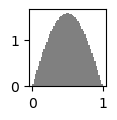

In [32]:
pl.figure(figsize=(1,1))
jc = orbital_circularity_satgen_zentner(1000000)
pl.hist(jc,bins=50,density=True,color='grey');

The `init.orbit` function looks like:

```python
def orbit(hp,xc=1.0,eps=0.5):
```
(full version below). According to the docstring,
```
        hp: host potential (a halo density profile object, as defined 
            in profiles.py) 
        xc: the orbital energy parameter, defined such that if the 
            energy of the orbit is E, x_c(E) is the radius of a circular 
            orbit in units of the host halo's virial radius (default=1.)
        eps: the orbital circularity parameter (default=0.5)
```
We have to specify the host potential. The SatGen `profiles.py` has a bunch of rountines for this. The resulting object has to be able to supply (for example) a virial radius, a circular velocity, and a potential. We're going to try and replace this stuff with halotools.

In [36]:
import halotools

The full `init.orbit` function:

```python
def orbit(hp,xc=1.0,eps=0.5):
    """
    Initialize the orbit of a satellite, given orbit energy proxy (xc) 
    and circularity (eps).  
    
    Syntax:
    
        orbit(hp,xc=1.,eps=0.5,)
        
    where
    
        hp: host potential (a halo density profile object, as defined 
            in profiles.py) 
        xc: the orbital energy parameter, defined such that if the 
            energy of the orbit is E, x_c(E) is the radius of a circular 
            orbit in units of the host halo's virial radius (default=1.)
        eps: the orbital circularity parameter (default=0.5)
            
    Return:
    
        phase-space coordinates in cylindrical frame 
        np.array([R,phi,z,VR,Vphi,Vz])
    """
    r0 = hp.rh
    rc = xc * hp.rh
    theta = np.arccos(2.*np.random.random()-1.) # i.e., isotropy
    zeta = 2.*np.pi*np.random.random() # i.e., uniform azimuthal 
        # angle, zeta, of velocity vector in theta-phi-r frame 
    Vc = hp.Vcirc(rc,)
    Phic = hp.Phi(rc,)
    Phi0 = hp.Phi(r0,)
    V0 = np.sqrt(Vc**2 + 2.*(Phic-Phi0)) 
    S = eps * rc/r0 * Vc/V0
    gamma = np.pi-np.arcsin(S) # angle between r and v vectors. Note that
        # we use pi - np.arcsin(S) instead of just np.arcsin(S), because 
        # the velocity needs to point inward the virial sphere.
    if S>1.: # a safety, may not be useful
        sys.exit('Invalid orbit! sin(gamma)=%.4f,xc=%4.2f,eps=%4.2f'\
            %(S,xc,eps))
    sintheta = np.sin(theta)
    costheta = np.cos(theta)
    singamma = np.sin(gamma)
    cosgamma = np.cos(gamma)
    sinzeta = np.sin(zeta)
    coszeta = np.cos(zeta)
    return np.array([
        r0 * sintheta,
        np.random.random() * 2.*np.pi,  # uniformly random phi in (0,2pi)
        r0 * costheta,
        V0 * ( singamma * coszeta * costheta + cosgamma * sintheta ),
        V0 * singamma * sinzeta,
        V0 * ( cosgamma * costheta - singamma * coszeta * sintheta ),
        ])
```

We can tidy this up...

In [44]:
import astropy.cosmology as cosmo
from halotools.empirical_models import NFWProfile

In [150]:
z_i = event['zred_i']
m_h = event['mhost']

lcdm = cosmo.FlatLambdaCDM(name="WMAP5", H0=70.2, Om0=0.277, Tcmb0=2.725, Neff=3.04, m_nu=[0,0,0], Ob0=0.0459)
nfw = NFWProfile(cosmology=lcdm, redshift=z_i, mdef='200c', 
                 conc_mass_model = 'dutton_maccio14')

# Are the EPS trees generating masses in h-inverse units or not?

m_halo_h_inverse = m_h*lcdm.h
c_nfw            = nfw.conc_NFWmodel(prim_haloprop=m_halo_h_inverse)
rvir_h_inverse   = nfw.halo_mass_to_halo_radius(m_halo_h_inverse)
rvir             = (rvir_h_inverse/lcdm.h)*u.Mpc
vcirc_halo       = nfw.circular_velocity(rvir_h_inverse, m_halo_h_inverse, c_nfw)

a_nfw = (rvir/c_nfw)
a_nfw

<Quantity 0.01948284 Mpc>

In [151]:
import astropy.constants as const
import astropy.units as u

G_astro = const.G.to(u.Mpc**3/(u.Msun*u.Gyr**2))
f_nfw = lambda x: (np.log(1.+x) - x/(1.+x))

From SatGen

$\rho_0 = \frac{\Delta \rho_c}{3} \frac{c^3}{f(c)}$

$\Phi_0 = \frac{4\pi G}{\rho_{0}} r_{s}^2$ 

$\Phi(x) = \Phi_0 \, \frac{\ln(1+x)}{x}$


In [160]:
def nfw_phi(R, c_nfw, a_nfw, zred=0, delta_halo=200):
    """
    """  
    disk_prefactor = 1.0 # See 'sf' in satgen.profiles
    z = 0.0

    # Note the units
    halo_rho0 = (lcdm.critical_density(zred)*delta_halo/3.0*c_nfw**3.0/f_nfw(c_nfw)).to(u.Msun/u.kpc**3)
    
    halo_Phi0 = (4*np.pi*G_astro*halo_rho0*(a_nfw**2)).to(u.kpc**2/u.Gyr**2)
    
    # The z here is a bit strange, not the redshift
    x = np.sqrt(R**2 + z**2)/a_nfw
    
    return -Phi0 * np.log(1.+x)/x

In [177]:
def orbit(z_i, m_halo, xc=1.0, eps=0.5, cosmology=None):
    """
    Initialize the orbit of a satellite, given orbit energy proxy (xc) 
    and circularity (eps).  
    
    Syntax:
    
        orbit(hp,xc=1.,eps=0.5,)
        
    where
    
        hp: host potential (a halo density profile object, as defined 
            in profiles.py) 
        xc: the orbital energy parameter, defined such that if the 
            energy of the orbit is E, x_c(E) is the radius of a circular 
            orbit in units of the host halo's virial radius (default=1.)
        eps: the orbital circularity parameter (default=0.5)
            
    Return:
    
        phase-space coordinates in cylindrical frame 
        np.array([R,phi,z,VR,Vphi,Vz])
    """
    if cosmology is None:
        cosmology = cosmo.FlatLambdaCDM(name="WMAP5", H0=70.2, Om0=0.277, Tcmb0=2.725, Neff=3.04, m_nu=[0,0,0], Ob0=0.0459)
        
    nfw = NFWProfile(cosmology=lcdm, redshift=z_i, mdef='vir', 
                     conc_mass_model = 'dutton_maccio14')

    # Halotools requires input in h^-1 and outputs h^-1
    m_halo_h_inverse = m_halo*lcdm.h
    c_nfw            = nfw.conc_NFWmodel(prim_haloprop=m_halo_h_inverse)
    rvir_h_inverse   = nfw.halo_mass_to_halo_radius(m_halo_h_inverse)
    rvir             = (rvir_h_inverse/lcdm.h)*u.Mpc
    a_nfw            = (rvir/c_nfw)
    
    # Scaled radius (not scale radius!) -- see SatGen
    rc = xc * rvir

    # Angle of velocity vector in theta-phi-r frame:
    # Random polar angle
    theta = np.arccos(2.*np.random.random()-1.)
    # Random azimuthal angle
    zeta   = 2.*np.pi*np.random.random()
    
    Vc   = nfw.circular_velocity(rvir_h_inverse, m_halo_h_inverse, c_nfw)*(u.km/u.s)
    Phic = nfw_phi(rc, c_nfw, a_nfw)
    Phi0 = nfw_phi(rvir, c_nfw, a_nfw)
    
    V0 = np.sqrt(Vc**2 + 2.*(Phic-Phi0)) 
    
    S = eps * rc/rvir * Vc/V0

    # From SatGen:
    # angle between r and v vectors. Note that
    # we use pi - np.arcsin(S) instead of just np.arcsin(S), because 
    # the velocity needs to point inward the virial sphere.
    gamma = np.pi - np.arcsin(S.value)
    
    if S>1.: # a safety, may not be useful
        sys.exit('Invalid orbit! sin(gamma)=%.4f,xc=%4.2f,eps=%4.2f'\
            %(S,xc,eps))
        
    sintheta = np.sin(theta)
    costheta = np.cos(theta)
    singamma = np.sin(gamma)
    cosgamma = np.cos(gamma)
    sinzeta  = np.sin(zeta)
    coszeta  = np.cos(zeta)
    return np.array([
        rvir * sintheta,
        np.random.random() * 2.*np.pi,  # uniformly random phi in (0,2pi)
        rvir * costheta,
        V0 * ( singamma * coszeta * costheta + cosgamma * sintheta ),
        V0 * singamma * sinzeta,
        V0 * ( cosgamma * costheta - singamma * coszeta * sintheta ),
        ], dtype='object')

In [178]:
orbit(z_i, m_h, xc=1.0, eps=0.5, cosmology=lcdm)

array([<Quantity 0.08250704 Mpc>, 5.637007679320519,
       <Quantity 0.07598995 Mpc>, <Quantity [-83.68959776] km / s>,
       <Quantity [-73.87964207] km / s>,
       <Quantity [-105.36984807] km / s>], dtype=object)

In [179]:
orbit(z_i, m_h, xc=1.0, eps=eps, cosmology=lcdm)

array([<Quantity 0.09218488 Mpc>, 5.650258066914984,
       <Quantity 0.06390486 Mpc>, <Quantity [-87.70164391] km / s>,
       <Quantity [-18.91409316] km / s>,
       <Quantity [-124.56176743] km / s>], dtype=object)

In [19]:
eps = 1./np.pi*np.arccos(1.-2.*np.random.random())
xv  = init.orbit(hp,xc=1.,eps=eps)

NameError: name 'init' is not defined